In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
from pyspark.sql.functions import col, lit, to_date, split, when, coalesce
from pyspark.sql.types import MapType, StringType
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pyspark.sql.functions import year
from pyspark.sql.functions import when, col, count, expr
from itertools import chain
from pyspark.sql.window import Window

In [2]:
spark = SparkSession.builder \
                    .appName('tennis_2') \
                    .getOrCreate()

In [3]:
rankings =spark.read.option("header","true").option("inferSchema","true") \
.csv('rankings')

#convert ranking_date to datetype column
rankings = rankings.withColumn("ranking_date", 
                         to_date(col("ranking_date").cast("string"), "yyyyMMdd"))

rankings.show(5)

+------------+----+------+------+
|ranking_date|rank|player|points|
+------------+----+------+------+
|  2020-01-06|   1|104745|  9985|
|  2020-01-06|   2|104925|  9055|
|  2020-01-06|   3|103819|  6590|
|  2020-01-06|   4|106233|  5825|
|  2020-01-06|   5|106421|  5705|
+------------+----+------+------+
only showing top 5 rows



In [4]:
#Obtain the most recent date
most_recent_date = rankings.select(F.max("ranking_date")).collect()[0][0]
most_recent_date

datetime.date(2024, 1, 1)

In [5]:
top_5 = rankings.filter(rankings.ranking_date == most_recent_date) \
                      .orderBy("rank") \
                      .limit(5)
top_5.show()

+------------+----+------+------+
|ranking_date|rank|player|points|
+------------+----+------+------+
|  2024-01-01|   1|104925| 11245|
|  2024-01-01|   2|207989|  8855|
|  2024-01-01|   3|106421|  7600|
|  2024-01-01|   4|206173|  6490|
|  2024-01-01|   5|126094|  4805|
+------------+----+------+------+



In [6]:
players = top_5.select("player").distinct() #select players
ranks_top5 = rankings.join(players, "player") \
                           .filter(rankings.ranking_date >= "2010-01-01") \
                           .orderBy("ranking_date")


ranks_top5.show(10)

+------+------------+----+------+
|player|ranking_date|rank|points|
+------+------------+----+------+
|104925|  2010-01-04|   3|  8310|
|104925|  2010-01-11|   3|  8310|
|104925|  2010-01-18|   3|  8310|
|104925|  2010-01-25|   3|  8310|
|104925|  2010-02-01|   2|  8310|
|104925|  2010-02-08|   2|  8310|
|104925|  2010-02-15|   2|  8310|
|104925|  2010-02-22|   2|  8310|
|104925|  2010-03-01|   2|  8310|
|104925|  2010-03-08|   2|  8310|
+------+------------+----+------+
only showing top 10 rows



In [9]:
singles = spark.read.option("header","true").option("inferSchema","true") \
.csv('singles')
rankings_with_names = ranks_top5.join(singles, ranks_top5.player == singles.winner_id, "left") \
                                        .select(ranks_top5["*"], singles["winner_name"].alias("player_name")) \
                                        .dropDuplicates()
rankings_with_names.show(5)

+------+------------+----+------+--------------+
|player|ranking_date|rank|points|   player_name|
+------+------------+----+------+--------------+
|206173|  2020-10-19|  46|  1136| Jannik Sinner|
|104925|  2021-08-30|   1| 11113|Novak Djokovic|
|104925|  2021-11-29|   1| 11540|Novak Djokovic|
|104925|  2021-11-22|   1| 11540|Novak Djokovic|
|206173|  2022-03-07|  10|  3495| Jannik Sinner|
+------+------------+----+------+--------------+
only showing top 5 rows



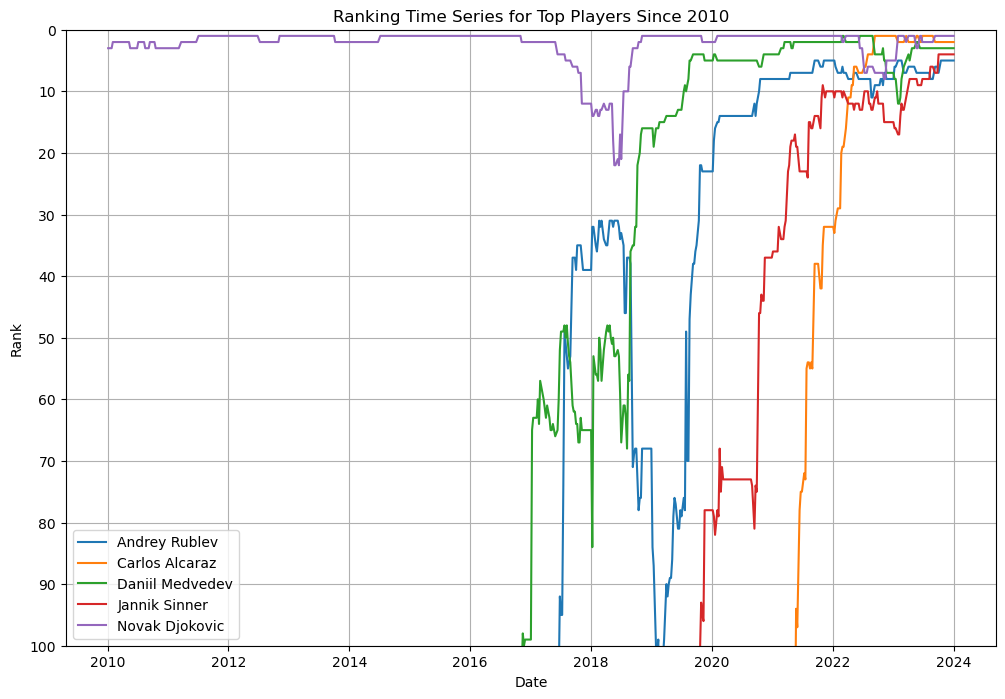

In [10]:
ranks_pd = rankings_with_names.toPandas()

pivoted = ranks_pd.pivot(index='ranking_date', columns='player_name', values='rank')


plt.figure(figsize=(12, 8))
for player in pivoted.columns:
    plt.plot(pivoted.index, pivoted[player], label=player)
plt.ylim(0, 100)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.title('Ranking Time Series for Top Players Since 2010')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [11]:
rankings_with_names = rankings_with_names.filter(rankings.ranking_date >= "2021-01-01") \
                           .orderBy("ranking_date")
rankings_with_names.show(5)

+------+------------+----+------+---------------+
|player|ranking_date|rank|points|    player_name|
+------+------------+----+------+---------------+
|106421|  2021-01-04|   4|  8470|Daniil Medvedev|
|104925|  2021-01-04|   1| 12030| Novak Djokovic|
|126094|  2021-01-04|   8|  4164|  Andrey Rublev|
|206173|  2021-01-04|  36|  1464|  Jannik Sinner|
|207989|  2021-01-04| 141|   464| Carlos Alcaraz|
+------+------------+----+------+---------------+
only showing top 5 rows



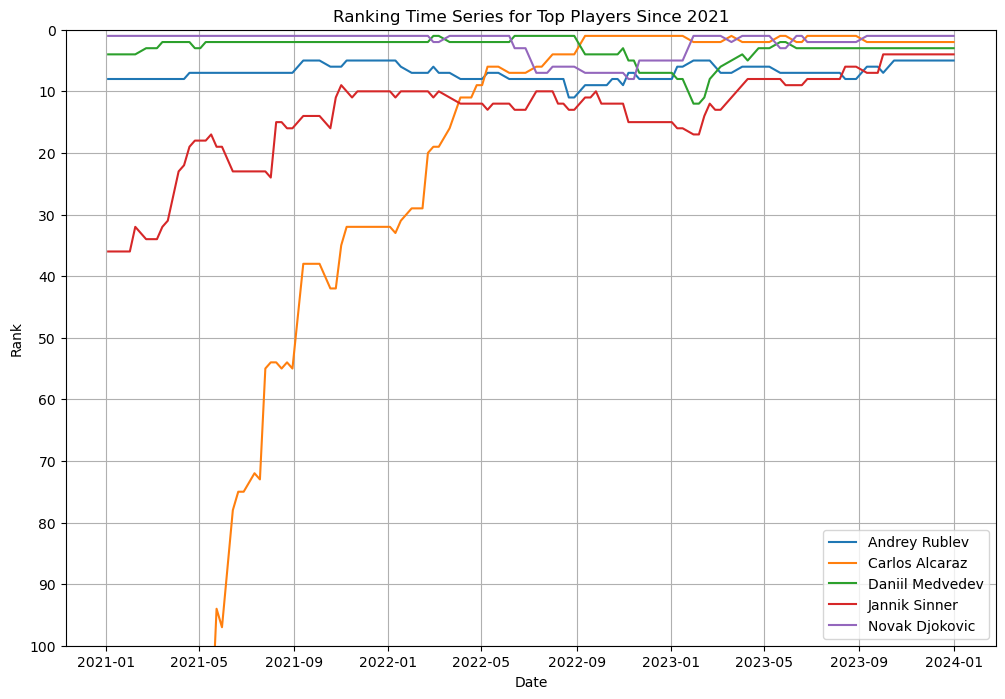

In [12]:
ranks_pd = rankings_with_names.toPandas()

pivoted = ranks_pd.pivot(index='ranking_date', columns='player_name', values='rank')


plt.figure(figsize=(12, 8))
for player in pivoted.columns:
    plt.plot(pivoted.index, pivoted[player], label=player)
plt.ylim(0, 100)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.title('Ranking Time Series for Top Players Since 2021')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.legend(loc='best')
plt.grid(True)
plt.show()